In [101]:
import os
import tensorflow as tf
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN, MeanShift, AgglomerativeClustering, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, silhouette_score, adjusted_mutual_info_score

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"

for dimension reduction look into LDA for class separability and SVD for sparse data
SVD may be better for image data for its versatility and noise reduction

In [2]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, data_directory, image_size=(128, 128)):
        self.data_directory = data_directory
        self.image_size = image_size
        
    def fit(self, X=None, y=None):
        return self
        
    def transform(self, X=None, y=None):
        images = []
        labels = []
        # get image labels from the folder names
        class_labels = os.listdir(self.data_directory)
        class_labels.sort()
        # loop through directory
        for label_idx, class_name in enumerate(class_labels):
            class_dir = os.path.join(self.data_directory, class_name)
            # wrong directory
            if not os.path.isdir(class_dir): 
                continue
            # loop through image files
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                # check for valid image to load
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    # load with opencv
                    img = cv2.imread(file_path)
                    # preprocessing
                    # resize
                    img_resized = cv2.resize(img, self.image_size)
                    # grayscale
                    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
                    # normalization
                    img_gray_norm = img_gray / 255.0
                    
                    # append image with label
                    images.append(img_gray_norm)
                    labels.append(label_idx)
                    
        # convert to numpy
        images = np.array(images)
        labels = np.array(labels)
        return images, labels

For Data Analysis of the Image Dataset

The name of each class and the number of images in the dataset are:
Cheetah: 38
Jaguar: 30
Leopard: 31
Lion: 32
Tiger: 39
Number of classes in this dataset is: 5


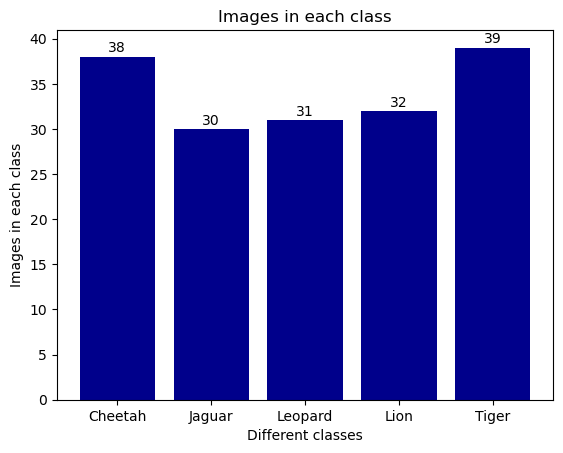

In [3]:
#To display the number of classes in the dataset
data_directory = 'data/BigCats'
count_classes = Counter()
class_labels = os.listdir(data_directory)
class_labels.sort()
i = 0

first_image_paths =[]
first_image_labels = []

for class_name in class_labels:
    class_dir = os.path.join(data_directory, class_name)
    if not os.path.isdir(class_dir):
        continue
    
    class_image_count = 0
    first_image_found = False

    for file_name in os.listdir(class_dir):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            class_image_count += 1
            if not first_image_found:
                file_path = os.path.join(class_dir, file_name)
                first_image_paths.append(file_path)
                first_image_labels.append(class_name)
                first_image_found = True

    count_classes[class_name] = class_image_count
    i += 1

print("The name of each class and the number of images in the dataset are:")
for class_name, count in count_classes.items():
    print(f"{class_name}: {count}")
print(f"Number of classes in this dataset is: {i}")

# Creating plot
plt.bar(count_classes.keys(), count_classes.values(), color = 'darkblue')
plt.title("Images in each class")
plt.xlabel("Different classes")
plt.ylabel("Images in each class")
for i, count in enumerate(count_classes.values()):
    plt.text(i, count + 0.5, str(count), ha='center', color='black')  # ha='center' centers the text


# show plot
plt.show()

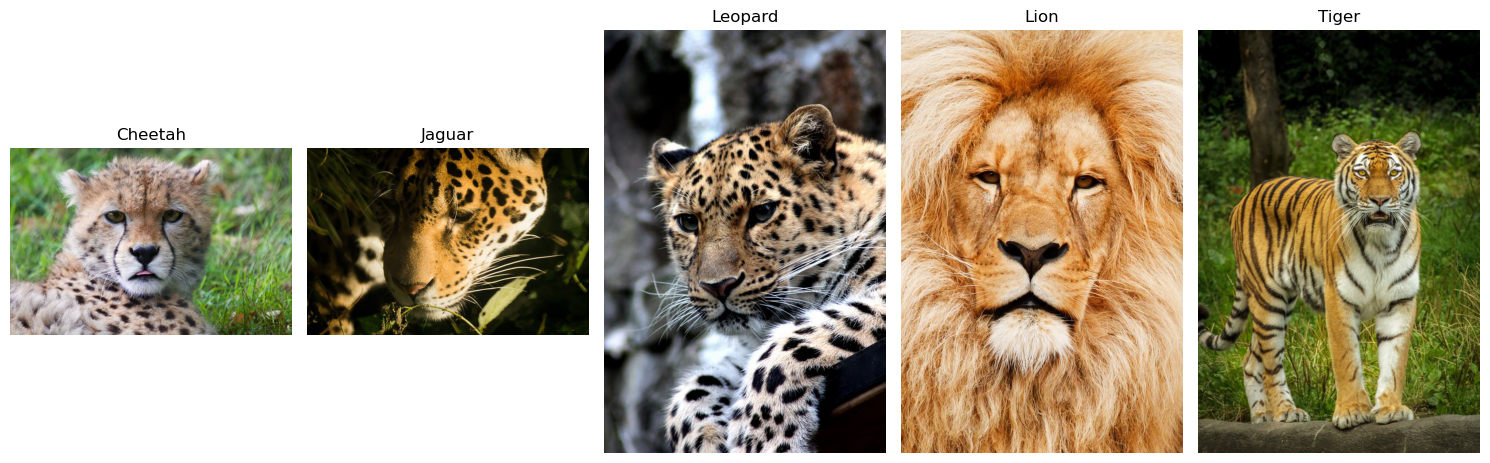

In [4]:
#To display one image from each class
if len(first_image_paths) > 0:
    # Display the first image from each class
    fig, axes = plt.subplots(1, len(first_image_paths), figsize=(15, 15))

    for idx, img_path in enumerate(first_image_paths):
        img = plt.imread(img_path) 
        axes[idx].imshow(img)
        axes[idx].set_title(first_image_labels[idx])
        axes[idx].axis('off') 

    plt.tight_layout()
    plt.show()
else:
    print("No images found in the dataset.")

Feature Selection and Dimenstionality Reduction

In [5]:
class SIFTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=500):
        # use opencv SIFT
        self.sift = cv2.SIFT_create()
        self.max_features = max_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sift_features = []
        for img in X:
            # SIFT takes in uint8 format images
            img_uint8 = (img * 255).astype(np.uint8)
            kp, des = self.sift.detectAndCompute(img_uint8, None)
            # features found
            if des is not None:
                des_flattened = des.flatten()
                # descriptors exceed max features truncate
                if len(des_flattened) > self.max_features:
                    des_flattened = des_flattened[:self.max_features]
                # descriptors shorter pad to max features
                else: 
                    des_flattened = np.pad(des_flattened, (0, self.max_features - len(des_flattened)), 'constant')
            # no features found
            else:
                des_flattened = np.zeros(self.max_features)
            sift_features.append(des_flattened)
        return np.array(sift_features)

In [6]:
class FourierFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fft_features = []
        for img in X:
            # fft
            f_transform = np.fft.fft2(img)
            # shift zero frequency to center
            f_shift = np.fft.fftshift(f_transform)
            magnitude_spectrum = 20 * np.log(np.abs(f_shift))
            fft_features.append(magnitude_spectrum.flatten())
        return np.array(fft_features)

In [7]:
class SVDReducer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=100):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=self.n_components)

    def fit(self, X, y=None):
        self.svd.fit(X)
        return self

    def transform(self, X):
        return self.svd.transform(X)

In [8]:
# set variable
#data_directory = 'data/BigCats'
RANDOM_SEED = 192
# kNN neighbors
number_neighbor = 5
# SVD components
n_components = 100

In [9]:
decision_tree = DecisionTreeClassifier(random_state=RANDOM_SEED)
naive_bayes = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=number_neighbor)
dbscan = DBSCAN(eps=0.5, min_samples=5)

In [10]:
# define the pipelines for different classification methods
sift_decision_tree_pipeline = Pipeline([
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
])
sift_naive_bayes_pipeline = Pipeline([
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', GaussianNB())
])
sift_knn_pipeline = Pipeline([
    ('sift', SIFTFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', KNeighborsClassifier(n_neighbors=number_neighbor))
])
fourier_decision_tree_pipeline = Pipeline([
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
])

fourier_naive_bayes_pipeline = Pipeline([
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', GaussianNB())
])

fourier_knn_pipeline = Pipeline([
    ('fourier', FourierFeatureExtractor()),
    ('svd', SVDReducer(n_components=n_components)),
    ('classifier', KNeighborsClassifier(n_neighbors=number_neighbor))
])

In [11]:
# data load and split
image_loader = ImageLoader(data_directory=data_directory, image_size=(128, 128))
images, labels = image_loader.fit_transform(None)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
print(X_train.shape)
print(y_train.shape)

(136, 128, 128)
(136,)


Classification

In [13]:
# example call so far
# still need parameter search
# maybe dimension reduction
# or other things
sift_decision_tree_pipeline.fit(X_train, y_train)
y_pred = sift_decision_tree_pipeline.predict(X_test)
print("SIFT + Decision Tree: Accuracy =", accuracy_score(y_test, y_pred), "F1-Score =", f1_score(y_test, y_pred, average='weighted'))
sift_naive_bayes_pipeline.fit(X_train, y_train)
y_pred = sift_naive_bayes_pipeline.predict(X_test)
print("SIFT + Naive Bayes: Accuracy =", accuracy_score(y_test, y_pred), "F1-Score =", f1_score(y_test, y_pred, average='weighted'))
sift_knn_pipeline.fit(X_train, y_train)
y_pred = sift_knn_pipeline.predict(X_test)
print("SIFT + KNN: Accuracy =", accuracy_score(y_test, y_pred), "F1-Score =", f1_score(y_test, y_pred, average='weighted'))
fourier_decision_tree_pipeline.fit(X_train, y_train)
y_pred = fourier_decision_tree_pipeline.predict(X_test)
print("Fourier + Decision Tree: Accuracy =", accuracy_score(y_test, y_pred), "F1-Score =", f1_score(y_test, y_pred, average='weighted'))
fourier_naive_bayes_pipeline.fit(X_train, y_train)
y_pred = fourier_naive_bayes_pipeline.predict(X_test)
print("Fourier + Naive Bayes: Accuracy =", accuracy_score(y_test, y_pred), "F1-Score =", f1_score(y_test, y_pred, average='weighted'))
fourier_knn_pipeline.fit(X_train, y_train)
y_pred = fourier_knn_pipeline.predict(X_test)
print("Fourier + KNN: Accuracy =", accuracy_score(y_test, y_pred), "F1-Score =", f1_score(y_test, y_pred, average='weighted'))

SIFT + Decision Tree: Accuracy = 0.17647058823529413 F1-Score = 0.15637254901960784
SIFT + Naive Bayes: Accuracy = 0.4117647058823529 F1-Score = 0.4084967320261437
SIFT + KNN: Accuracy = 0.29411764705882354 F1-Score = 0.25085943468296407
Fourier + Decision Tree: Accuracy = 0.3235294117647059 F1-Score = 0.3144669632558906
Fourier + Naive Bayes: Accuracy = 0.4411764705882353 F1-Score = 0.3989050165520754
Fourier + KNN: Accuracy = 0.4117647058823529 F1-Score = 0.4149177619765855


Clustering

In [134]:
#Using Gaussian mixture Models for clustering
def gmm_clustering(X, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_SEED)
    gmm_labels = gmm.fit_predict(X)
    return gmm_labels, gmm

#To evaluate the clustering 
def evaluation_metrics(X, labels_true, labels_pred):
    n_clusters = len(np.unique(labels_pred))
    # If less than 2 clusters are found, skip silhouette score calculation
    if n_clusters < 2:
        silhouette = None
        print("Silhouette score cannot be calculated, only one cluster found.")
    else:
        silhouette = silhouette_score(X, labels_pred)

    
    #silhouette = silhouette_score(X, labels_pred)
    mutulal_info = adjusted_mutual_info_score(labels_true, labels_pred)
    return silhouette, mutulal_info




In [135]:
#Clustering of the SIFT reduced dataset
X_train_sift = sift_knn_pipeline.named_steps['sift'].transform(X_train)
X_train_sift_svd = sift_knn_pipeline.named_steps['svd'].transform(X_train_sift)
sift_gmm, _ = gmm_clustering(X_train_sift_svd, n_components)
sift_gmm_silhouette, sift_gmm_mi = evaluation_metrics(X_train_sift_svd, y_train, sift_gmm)

#Clustering of the Fourier reduced dataset
X_train_fourier = fourier_knn_pipeline.named_steps['fourier'].transform(X_train)
X_train_fourier_svd = fourier_knn_pipeline.named_steps['svd'].transform(X_train_fourier)
fourier_gmm, _ = gmm_clustering(X_train_fourier_svd,n_components)
fourier_gmm_silhouette, fourier_gmm_mi = evaluation_metrics(X_train_fourier_svd, y_train, fourier_gmm)

#To print the Silhouette Score and the Mutal Information values
print(f"Gaussian Mixture Model on SIFT: Silhouette Score - {sift_gmm_silhouette} , Mutal Information Values - {sift_gmm_mi}")
print(f"Gaussian Mixture Model on Fourier: Silhouette Score - {fourier_gmm_silhouette} , Mutal Information Values - {fourier_gmm_mi}")

c:\Users\amrut\anaconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Gaussian Mixture Model on SIFT: Silhouette Score - 0.08271242678165436 , Mutal Information Values - 0.012875011873673238
Gaussian Mixture Model on Fourier: Silhouette Score - 0.08447371485853446 , Mutal Information Values - 0.01567642634829991


c:\Users\amrut\anaconda3\envs\ai_env\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Grid Search